## Imports

In [ ]:
# Imports
import numpy as np
from math import sqrt
from queue import PriorityQueue
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

## Funções Auxiliares

In [ ]:
def criterioParada(iter):
    # Número máximo de iterações
    k = 300

    return iter < k

In [ ]:
def calculaEsperaMedia(chegadas, saidas):
  media = 0
  for (chegada, saida) in zip(chegadas, saidas):
    media += saida - chegada

  media = media / len(saidas)
  return media

In [ ]:
def calculaMediaDeClientes(trace):
  area = 0
  tempo_simulacao = 0

  # Lei de Little
  for (tempo_evento, tipo_evento, pessoas_no_sistema) in trace:
    if tipo_evento == "C": area += (tempo_evento - tempo_simulacao)*(pessoas_no_sistema - 1)
    if tipo_evento == "S": area += (tempo_evento - tempo_simulacao)*(pessoas_no_sistema + 1)

    tempo_simulacao = tempo_evento

  return area/tempo_simulacao

In [ ]:
def calculaIntervaloDeConfianca(lista_valores, media, n_experimentos):
  z = 1.96
  variancia = sum([(x - media)**2 for x in lista_valores])/n_experimentos
  desvio_padrao = sqrt(variancia)
  intervalo_de_confianca = [media - z * desvio_padrao / sqrt(n_experimentos), media + z * desvio_padrao / sqrt(n_experimentos)]

  return intervalo_de_confianca

In [ ]:
def estimativas(lista_chegadas, lista_saidas, lista_media_clientes, num_simulacoes, lista_tempos, clientes_atendidos, trace):
  lista_esperas = []
  lista_media_clientes = []

  for i in range(num_simulacoes):
    lista_esperas.append(calculaEsperaMedia(lista_chegadas[i], lista_saidas[i]))
    lista_media_clientes.append(calculaMediaDeClientes(trace[i]))

  tempo_medio = sum(lista_esperas) / num_simulacoes
  qtd_media_clientes = sum(lista_media_clientes) / num_simulacoes

  intervalo_esperas = calculaIntervaloDeConfianca(lista_esperas, tempo_medio, num_simulacoes)
  intervalo_qtd_clientes = calculaIntervaloDeConfianca(lista_media_clientes, qtd_media_clientes, num_simulacoes)

  return (tempo_medio, qtd_media_clientes), (intervalo_esperas, intervalo_qtd_clientes)

In [ ]:
def showCDF(dados, is_discrete):
  size = len(dados)
  if(is_discrete):
    pdf = dict(zip((set(dados)), [0]*len(dados)))
    for value in dados:
      pdf[value] += 1

    prob = 0
    cdf = {}
    for (key, occur) in pdf.items():
      prob += occur
      cdf[key] = prob/size

    plt.bar(cdf.keys(), cdf.values())
    plt.title("CDF do Número de Clientes no Sistema\n (da última simulação)")
    plt.show()
    print("")
    return

  else:
    dados.sort()
    plt.plot(dados, list(x/size for x in range(size)))
    plt.title("CDF do Tempo Médio de Espera no Sistema\n (da última simulação)")
    plt.show()

In [ ]:
def geraMediasEGraficos(n_simulacoes, _lambda, _mu, criterioParada):
  n_simulacoes = 1000

  lista_chegadas = []
  lista_saidas = []
  lista_media_clientes = []
  lista_tempos = []
  retornos = []
  clientes_atendidos = []
  trace = []

  for i in range(n_simulacoes):
    retornos = fila_exponencial(_lambda, _mu, criterioParada, False)
    lista_chegadas.append(retornos[0])
    lista_saidas.append(retornos[2])
    lista_media_clientes.append(retornos[4])
    lista_tempos.append(retornos[7])
    clientes_atendidos.append(retornos[8])
    trace.append(retornos[9])

  (tempo_medio, num_medio_clientes), (intervalo_tempo, intervalo_clientes) = \
  estimativas(lista_chegadas, lista_saidas, lista_media_clientes, n_simulacoes, lista_tempos, clientes_atendidos, trace)

  showCDF(retornos[3], False)

  print("Tempo médio no sistema: {0:.6f}".format(tempo_medio))
  print("Intervalo de confiança do tempo médio: [{0:.6f}, {1:.6f}]\n".format(intervalo_tempo[0], intervalo_tempo[1]))

  showCDF(retornos[6], True)

  print("Número médio de clientes no sistema: {0:.6f}".format(num_medio_clientes))
  print("Intervalo de confiança do número médio de clientes: [{0:.6f}, {1:.6f}]\n".format(intervalo_clientes[0], intervalo_clientes[1]))
  return

## Função de Simulação da Fila (loop principal!)

In [ ]:
# Cria e simula Fila M/M/1 dados mu, lambda e criteiro de parada
def fila_exponencial(_lambda, _mu, parada, printTrace):

  # Gerador de números aleatórios
  rng = np.random.default_rng()

  # Fila de prioridades
  queue = PriorityQueue()

  # Tempo em que o cliente chega ao sistema
  tempo_chegada = []

  # Tempo em que o cliente começa a ser servido
  tempo_inicio_servico = []

  # Tempo em que o cliente termina de ser servido
  tempo_saida = []

  # Tempo que o cliente ficou no sistema (diferença entre fim e início do serviço)
  duracao_espera = []

  # Amostragem do tempo
  amostragens = []

  # Número de Clientes do sistema
  clientes_no_sistema = []

  rodada = 0
  tempo_simulacao = 0
  pessoas_no_sistema = 0

  # Número de clientes atendidos
  atendimentos = 0

  # Média de clientes no sistema
  media_clientes = 0

  # Trace com (tempo do evento, tipo do evento, pessoas no sistema)
  trace = []

  # Chegada Inicial
  queue.put((rng.exponential(1/_lambda), "C"))

  # Loop da Simulação
  while(parada(rodada)):
    # Remoção do elemento na cabeça da fila
    tempo, evento = queue.get()
    amostragens.append(tempo - tempo_simulacao)
    tempo_simulacao = tempo

    # Tratamento do evento
    if(evento == "C"):
      tempo_chegada.append(tempo_simulacao)
      pessoas_no_sistema += 1
      media_clientes += pessoas_no_sistema
      clientes_no_sistema.append(pessoas_no_sistema)

      queue.put((tempo_simulacao + rng.exponential(1/_lambda), "C"))

      if(pessoas_no_sistema == 1):
        tempo_inicio_servico.append(tempo_simulacao)
        queue.put((tempo_simulacao + rng.exponential(1/_mu), "S"))

      trace.append((tempo_simulacao, "C", pessoas_no_sistema))
      if(printTrace):
        # Trace
        print("====================")
        print("Evento: Chegada; Tempo = {0:.6f}; Nº de Clientes no Sistema = {1};\nRodada da Simulação: {2}; Nº de Clientes Atendidos:{3}"\
                .format(tempo_simulacao, pessoas_no_sistema, rodada+1, atendimentos))

    else:
      pessoas_no_sistema -= 1
      media_clientes += pessoas_no_sistema
      clientes_no_sistema.append(pessoas_no_sistema)

      if(pessoas_no_sistema > 0):
        tempo_inicio_servico.append(tempo_simulacao)
        queue.put((tempo_simulacao + rng.exponential(1/_mu), "S"))

      duracao_espera.append(tempo_simulacao - tempo_chegada[atendimentos])
      atendimentos += 1
      tempo_saida.append(tempo_simulacao)

      trace.append((tempo_simulacao, "S", pessoas_no_sistema))
      if(printTrace):
        # Trace
        print("====================")
        print("Evento:   Saída; Tempo = {0:.6f}; Nº de Clientes no Sistema = {1};\nRodada da Simulação: {2}; Nº de Clientes Atendidos:{3}"\
              .format(tempo_simulacao, pessoas_no_sistema, rodada+1, atendimentos))

    rodada += 1


  media_clientes = media_clientes/(rodada + 1)
  return tempo_chegada, tempo_inicio_servico, tempo_saida, duracao_espera, media_clientes, amostragens, clientes_no_sistema, tempo_simulacao, atendimentos, trace

# 4) M/M/1 Básica e Variantes (20 pontos)

## Cenário 1

In [ ]:
# Fila 1
_lambda = 1
_mu = 2

# Altere o valor para False caso não queira o Trace da simulação
printTrace = True
retornos1 = fila_exponencial(_lambda, _mu, criterioParada, printTrace)

Evento: Chegada; Tempo = 0.063457; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 1; Nº de Clientes Atendidos:0
Evento:   Saída; Tempo = 0.673556; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 2; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 1.479699; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 3; Nº de Clientes Atendidos:1
Evento:   Saída; Tempo = 1.511978; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 4; Nº de Clientes Atendidos:2
Evento: Chegada; Tempo = 1.711244; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 5; Nº de Clientes Atendidos:2
Evento:   Saída; Tempo = 1.879762; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 6; Nº de Clientes Atendidos:3
Evento: Chegada; Tempo = 2.890342; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 7; Nº de Clientes Atendidos:3
Evento:   Saída; Tempo = 3.014484; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 8; Nº de Clientes Atendidos:4
Evento: Chegada; Tempo = 3.635780; Nº de Clientes no Sistema = 1

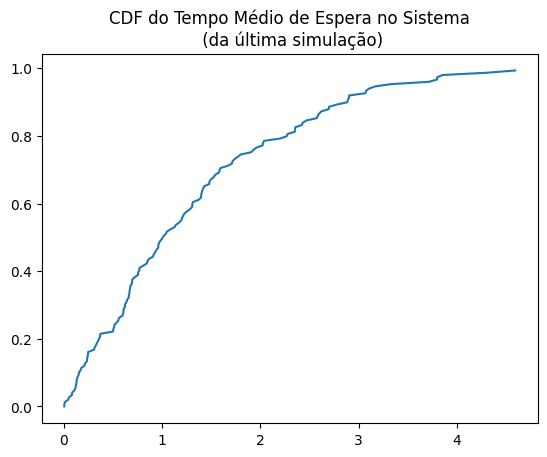

Tempo médio no sistema: 0.979371
Intervalo de confiança do tempo médio: [0.964943, 0.993799]



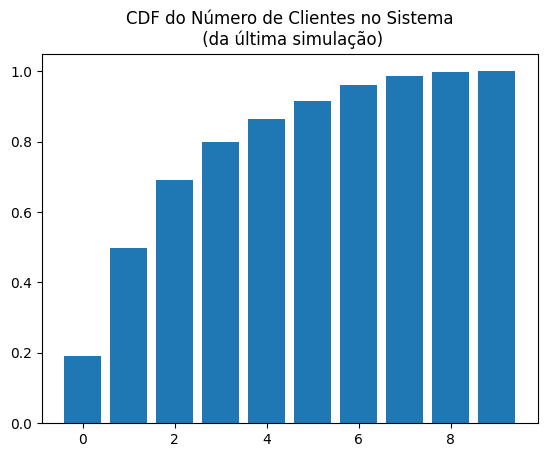


Número médio de clientes no sistema: 0.987228
Intervalo de confiança do número médio de clientes: [0.970225, 1.004232]



In [ ]:
geraMediasEGraficos(n_simulacoes=1000, _lambda=_lambda, _mu=_mu, criterioParada=criterioParada)

## Cenário 2

In [ ]:
# Fila 2
_lambda = 2
_mu = 4

# Altere o valor para False caso não queira o Trace da simulação
printTrace = True
retornos2 = fila_exponencial(_lambda, _mu, criterioParada, printTrace)

Evento: Chegada; Tempo = 0.682520; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 1; Nº de Clientes Atendidos:0
Evento:   Saída; Tempo = 0.790207; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 2; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 0.838405; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 3; Nº de Clientes Atendidos:1
Evento:   Saída; Tempo = 0.944085; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 4; Nº de Clientes Atendidos:2
Evento: Chegada; Tempo = 1.147869; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 5; Nº de Clientes Atendidos:2
Evento:   Saída; Tempo = 1.283619; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 6; Nº de Clientes Atendidos:3
Evento: Chegada; Tempo = 1.449532; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 7; Nº de Clientes Atendidos:3
Evento:   Saída; Tempo = 1.641254; Nº de Clientes no Sistema = 0;
Rodada da Simulação: 8; Nº de Clientes Atendidos:4
Evento: Chegada; Tempo = 2.264794; Nº de Clientes no Sistema = 1

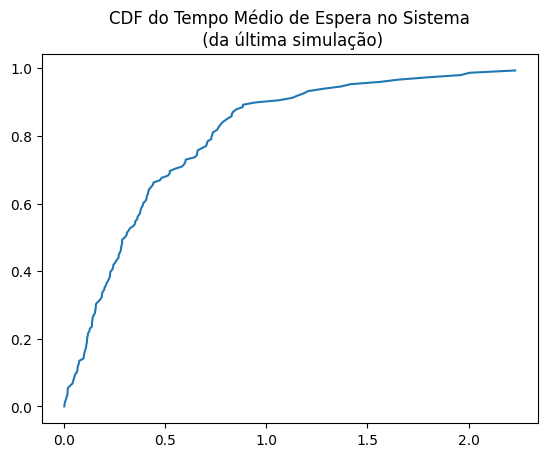

Tempo médio no sistema: 0.488603
Intervalo de confiança do tempo médio: [0.481251, 0.495955]



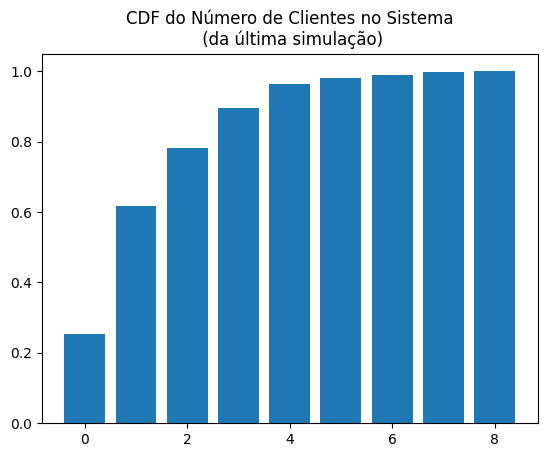


Número médio de clientes no sistema: 0.988027
Intervalo de confiança do número médio de clientes: [0.969949, 1.006105]



In [ ]:
geraMediasEGraficos(n_simulacoes=1000, _lambda=_lambda, _mu=_mu, criterioParada=criterioParada)

## Cenário 3

In [ ]:
# Fila 3
_lambda = 4
_mu = 2

# Altere o valor para False caso não queira o Trace da simulação
printTrace = True
retornos3 = fila_exponencial(_lambda, _mu, criterioParada, printTrace)

Evento: Chegada; Tempo = 0.400068; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 1; Nº de Clientes Atendidos:0
Evento: Chegada; Tempo = 0.466070; Nº de Clientes no Sistema = 2;
Rodada da Simulação: 2; Nº de Clientes Atendidos:0
Evento:   Saída; Tempo = 0.685364; Nº de Clientes no Sistema = 1;
Rodada da Simulação: 3; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 0.749309; Nº de Clientes no Sistema = 2;
Rodada da Simulação: 4; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 0.793978; Nº de Clientes no Sistema = 3;
Rodada da Simulação: 5; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 1.276918; Nº de Clientes no Sistema = 4;
Rodada da Simulação: 6; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 1.293945; Nº de Clientes no Sistema = 5;
Rodada da Simulação: 7; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 1.376231; Nº de Clientes no Sistema = 6;
Rodada da Simulação: 8; Nº de Clientes Atendidos:1
Evento: Chegada; Tempo = 1.417541; Nº de Clientes no Sistema = 7

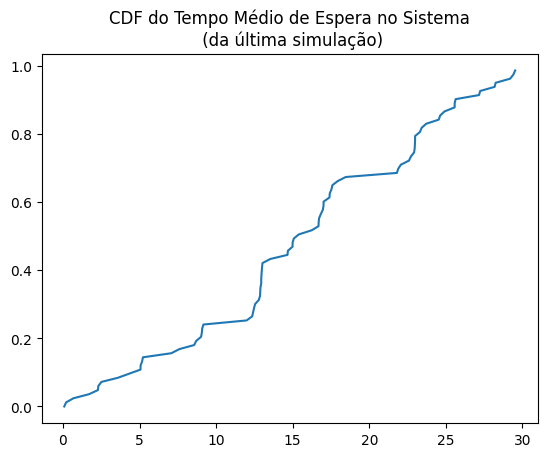

Tempo médio no sistema: 12.734368
Intervalo de confiança do tempo médio: [12.589504, 12.879233]



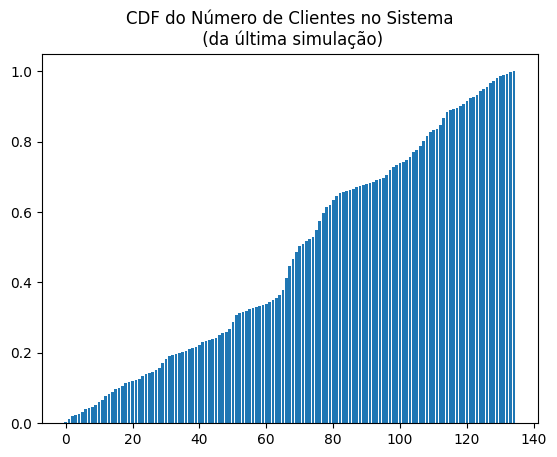


Número médio de clientes no sistema: 50.500982
Intervalo de confiança do número médio de clientes: [49.938953, 51.063011]



In [ ]:
geraMediasEGraficos(n_simulacoes=1000, _lambda=_lambda, _mu=_mu, criterioParada=criterioParada)

## 4.1) Simulação para verificar os resultados analíticos

### Método 1: Construindo a Cadeia de Markov, e resolvendo-a

Cadeia de Markov (tempo contínuo):

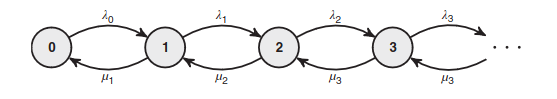

Matriz de taxas de transição:

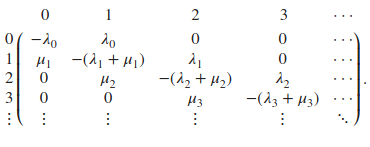

No nosso caso, $\lambda_0 = \lambda_1 =\ ...\ = \lambda_n = 1$, e $\mu_0 = \mu_1 =\ ...\ = \mu_n = 10$

$Q = \begin{bmatrix}
-1 & 1 & 0 & 0 & 0 & ... \\
10 & -11 & 1 & 0 & 0 & ... \\
0 & 10 & -11 & 1 & 0 & ... \\
0 & 0 & 10 & -11 & 1 & ... \\
\vdots & \vdots & \vdots & \vdots & \vdots &
\end{bmatrix}$

Para resolver a cadeia (isto é, encontrar uma solução estacionária), vamos utilizar do resultado para birth-death chains:

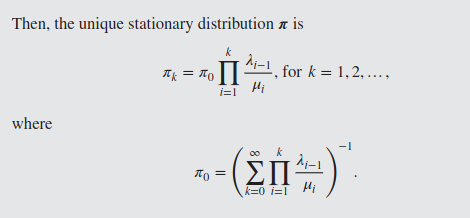

Vamos simplificar as parcelas dos cálculos para nossa aplicação. Como $\lambda$ e $\mu$ são os mesmos para todos os estados:

$$\prod_{i=1}^{k} \frac{\lambda_{i-1}}{\mu_i} = \frac{\lambda^{k}}{\mu^k} = \frac{1^k}{10^k} = \frac{1}{10^k}$$

E logo, o somatório de $\pi_0$ pode ser calculado como:

$$\sum_{k=0}^{\infty} \prod_{i=1}^{k} \frac{\lambda_{i-1}}{\mu_i} = \sum_{k=0}^{\infty} \frac{1}{10^k} = \frac{10}{9}$$

Sendo assim:

$$\pi_0 = \frac{9}{10}$$

E já podemos calcular os próximos elementos. Porém, como nosso caso é simples, vamos optar por não utilizar a fórmula geral, mas sim a fórmula "iterativa" derivada de:



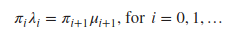

Para calcularmos o próximo elemento utilizando o elemento anterior:

$$\pi_i \lambda_i = \pi_{i+1}\mu_{i+1}\ \Rightarrow\ \pi_{i+1} = \frac{\pi_i \lambda_i}{\mu_{i+1}}$$

Porém, novamente, como $\lambda$ e $\mu$ são os mesmos para todos os estados:

$$\pi_{i+1} = \frac{\pi_i \lambda}{\mu} = \pi_i \frac{\lambda}{\mu} = \pi_i \rho = \pi_i \frac{1}{10}$$

E podemos facilmente gerar nossa solução estacionária:

$$\pi = (\frac{9}{10^1}, \frac{9}{10^2}, \frac{9}{10^3},\ ...\ , \frac{9}{10^k},\ ...)$$

Ou, com números decimais:

$$\pi = (0.9, 0.09, 0.009,\ ...\ )$$

Esta solução nos diz qual a probabilidade de estarmos no estado $i$ (isto é, de existirem $i$ clientes no sistema) ao olharmos para o sistema em um momento qualquer.

Vamos, também, calcular as 2 outras métricas de nosso interesse: O número médio de clientes no sistema em um momento qualquer e o tempo médio de espera dos clientes no sistema.

O número médio de clientes no sistema é $\frac{\rho}{1-\rho}$, no nosso caso:

$$E(N) = \frac{0.1}{1-0.1} = \frac{1}{9} ≈ 0.111111$$

E, pela Lei de Little:

$$L = \lambda W$$

Logo, para descobrirmos o tempo médio que um cliente fica no sistema, basta substituirmos $\lambda$ pela taxa de chegadas e $L$ pelo número médio de clientes no sistema:

$$ W = \frac{L}{\lambda} = \frac{1/9}{1} = \frac{1}{9} ≈ 0.111111$$

### Método 2: via simulação por eventos discretos

In [ ]:
_lambda = 1
_mu = 10

# rho = 0.1
_rho = _lambda/_mu

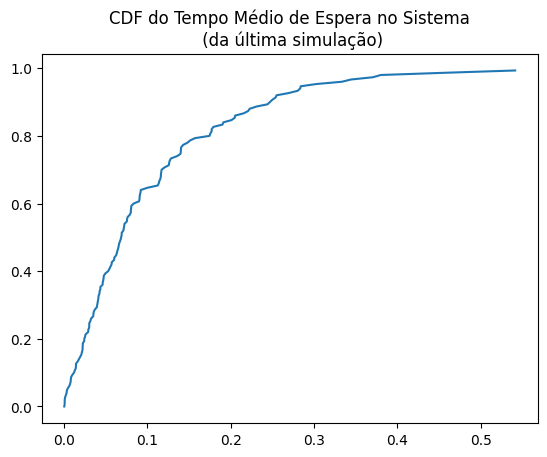

Tempo médio no sistema: 0.110885
Intervalo de confiança do tempo médio: [0.110213, 0.111557]



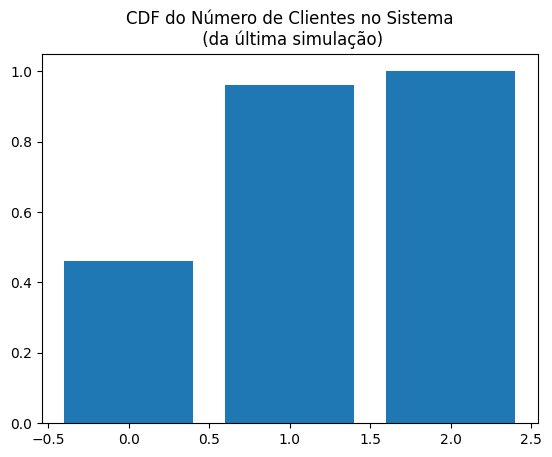


Número médio de clientes no sistema: 0.111573
Intervalo de confiança do número médio de clientes: [0.110648, 0.112499]



In [ ]:
geraMediasEGraficos(n_simulacoes=1000, _lambda=_lambda, _mu=_mu, criterioParada=criterioParada)

### Método 3: via Cadeia de Markov finita

Temos nossa matriz $Q$ infinita, porém, para podermos resolvê-la pelo método da potência, vamos truncá-la. Nas simulações podemos observar que difcilmente chegamos no estado de 4 pessoas no sistema (a probabilidade de estar nele em algum momento de tempo é de $0.09\%$, de acordo com nosso vetor $\pi$). Vamos colocar uma margem de erro bem grande e truncar nossa matriz em 20 estados (Probabilidade ínfima de alcançar este estado, dado $\rho = 0.1$).

Vamos chamar nossa matriz $Q$ truncada de $Q^{*}$





In [ ]:
#Tamanho a truncar
n = 20

Q_truncada = []
for i in range(n):
  linha = [0]*n
  if(i == 0):
    linha[0] = -_lambda
    linha[1] = _lambda

  elif(i == n-1):
    linha[i-1] = _mu
    linha[i] = -_mu

  else:
    linha[i-1] = _mu
    linha[i] = -(_lambda + _mu)
    linha[i+1] = _lambda

  print(linha)
  Q_truncada.append(linha)

Q_truncada = np.asarray(Q_truncada)

[-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, -11, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

E calculamos nossa $R$: $R\ =\ \frac{1}{\lambda}Q + I$, com $\lambda = 11$ (maior valor absoluto da diagonal, $\lambda + \mu$)

In [ ]:
R = (1/(_lambda+_mu)) * Q_truncada + np.identity(n)

for i in range(n):
  print(list(R[i]))

[0.9090909090909091, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9090909090909092, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9090909090909092, 0.0, 0.09090909090909091,

Usando o método da potência:

In [ ]:
R_n = matrix_power(R, 100)

for i in range(n):
  print(list(R_n[i]))

[0.8999999999999951, 0.08999999999999958, 0.008999999999999952, 0.0008999999999999956, 8.999999999999954e-05, 8.999999999999954e-06, 8.999999999999958e-07, 8.999999999999956e-08, 8.999999999999953e-09, 8.999999999999962e-10, 8.999999999999964e-11, 8.999999999999956e-12, 8.999999999999961e-13, 8.99999999999996e-14, 8.999999999999968e-15, 8.999999999999965e-16, 8.999999999999964e-17, 8.999999999999969e-18, 8.999999999999975e-19, 8.99999999999997e-20]
[0.8999999999999955, 0.08999999999999962, 0.008999999999999954, 0.0008999999999999957, 8.999999999999956e-05, 8.999999999999956e-06, 8.999999999999961e-07, 8.999999999999958e-08, 8.999999999999958e-09, 8.999999999999965e-10, 8.999999999999962e-11, 8.999999999999962e-12, 8.999999999999962e-13, 8.999999999999963e-14, 8.999999999999973e-15, 8.999999999999967e-16, 8.99999999999997e-17, 8.999999999999972e-18, 8.999999999999977e-19, 8.999999999999971e-20]
[0.8999999999999952, 0.0899999999999996, 0.008999999999999954, 0.0008999999999999956, 8.99999

E temos a solução estacionária nas linhas, $\approx (0.9, 0.09, 0.009,\ ...\ )$, que está de acordo com nosso $\pi$ calculado anteriormente.

# 5) Epidemias

## 5.1) Fração de períodos ocupados que terminam (40 pontos)

In [ ]:
def calculaFracao(traces, heuristica):
  lista_finitas = []
  lista_infinitas = []
  lista_razoes = []

  for trace in traces:
    pessoas = 0
    ocupado = False
    rodadas_ocupado = 0
    finitas = 0
    infinitas = 0

    for (tempo_evento, tipo_evento, pessoas_no_sistema) in trace:
      if(pessoas_no_sistema > 0):
        rodadas_ocupado += 1
        if(not ocupado):
          ocupado = True

      if(pessoas_no_sistema == 0 and ocupado):
        ocupado = False
        finitas += 1
        rodadas_ocupado = 0

    if(rodadas_ocupado > heuristica):
      infinitas += 1

    lista_finitas.append(finitas)
    lista_infinitas.append(infinitas)
    lista_razoes.append(finitas/(finitas + infinitas))

  return lista_finitas, lista_infinitas, lista_razoes


In [ ]:
def fracao_arvores_finitas(heuristica, _lambda, _mu):
  n_simulacoes = 1000
  traces = []

  for i in range(n_simulacoes):
    retornos = fila_exponencial(_lambda, _mu, criterioParada, False)
    traces.append(retornos[9])

  lista_finitas, lista_infinitas, lista_razoes = calculaFracao(traces, heuristica)

  numerador = sum(lista_finitas)
  denominador = sum(lista_infinitas)
  razao_media = numerador/(numerador + denominador)

  intervalo_razoes = calculaIntervaloDeConfianca(lista_razoes, razao_media, n_simulacoes)

  return numerador, denominador, razao_media, intervalo_razoes

## Caso 1

In [ ]:
# Mais de 50 períodos ocupados consecutivos será uma árvore infinta
heuristica = 50
_lambda = 1
_mu = 2

numerador, denominador, razao_media, intervalo_razoes = fracao_arvores_finitas(heuristica, _lambda, _mu,)

print("Árvores Finitas: {0}; Árvores Infinitas: {1}".format(numerador, denominador))
print("Fração de árvore finitas: {0}/{1} = {2:.6f}".format(numerador, numerador + denominador, razao_media))
print("Intervalo de confiança da fração de árvores: [{0:.6f}, {1:.6f}]\n".format(intervalo_razoes[0], intervalo_razoes[1]))

Árvores Finitas: 75237; Árvores Infinitas: 5
Fração de árvore finitas: 75237/75242 = 0.999934
Intervalo de confiança da fração de árvores: [0.999866, 1.000001]



## Caso 2

In [ ]:
# Mais de 50 períodos ocupados consecutivos será uma árvore infinta
heuristica = 50
_lambda = 2
_mu = 4

numerador, denominador, razao_media, intervalo_razoes = fracao_arvores_finitas(heuristica, _lambda, _mu,)

print("Árvores Finitas: {0}; Árvores Infinitas: {1}".format(numerador, denominador))
print("Fração de árvore finitas: {0}/{1} = {2:.6f}".format(numerador, numerador + denominador, razao_media))
print("Intervalo de confiança da fração de árvores: [{0:.6f}, {1:.6f}]\n".format(intervalo_razoes[0], intervalo_razoes[1]))

Árvores Finitas: 75637; Árvores Infinitas: 3
Fração de árvore finitas: 75637/75640 = 0.999960
Intervalo de confiança da fração de árvores: [0.999889, 1.000032]



## Caso 3

In [ ]:
# Mais de 50 períodos ocupados consecutivos será uma árvore infinta
heuristica = 50
_lambda = 4
_mu = 2

numerador, denominador, razao_media, intervalo_razoes = fracao_arvores_finitas(heuristica, _lambda, _mu,)

print("Árvores Finitas: {0}; Árvores Infinitas: {1}".format(numerador, denominador))
print("Fração de árvores finitas: {0}/{1} = {2:.6f}".format(numerador, numerador + denominador, razao_media))
print("Intervalo de confiança da fração de árvores: [{0:.6f}, {1:.6f}]\n".format(intervalo_razoes[0], intervalo_razoes[1]))

Árvores Finitas: 990; Árvores Infinitas: 1000
Fração de árvores finitas: 990/1990 = 0.497487
Intervalo de confiança da fração de árvores: [0.475027, 0.519948]



## Relação com $s = G(s)$

Os cenários 1 e 2 têm $\rho =0.5$, que são casos subcríticos ($\rho \leq 1$). Logo a probabilidade de extinção é igual a 1, o que está de acordo com o resultado e o intervalo de confiança das 2 primeiras simulações.

No cenário 3, temos $\rho = 2$, e portanto estamos no caso supercrítico ($\rho > 1$). Logo, vamos calcular $s = G(s)$ para encontrarmos a menor raíz da equação e determinarmos a probabilidade de eventual extinção.

$$G(s) = e^{\frac{\lambda}{\mu}(s - 1)}; \lambda = 4, \mu = 2$$

$$s = e^{2(s-1)}$$

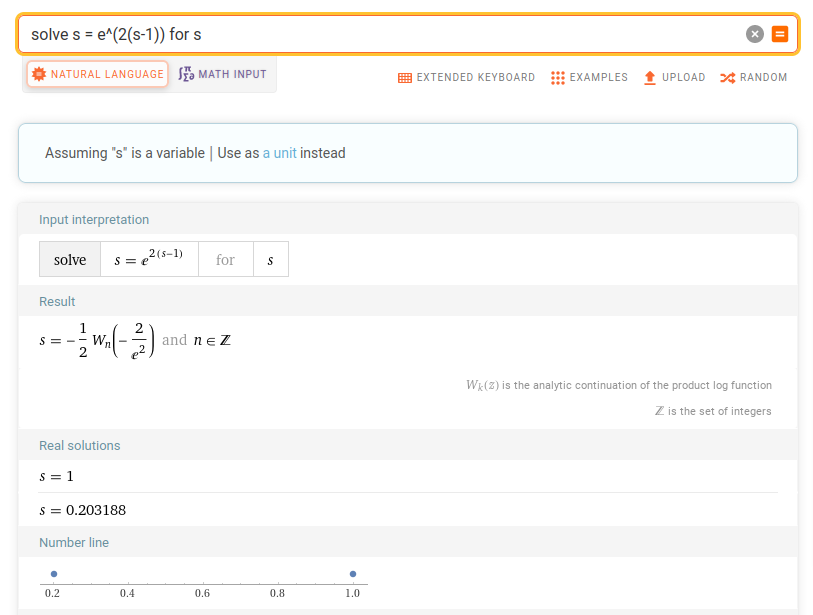

A menor raiz é $s = 0.203188 ≈ 20.31\%$, o que não está de acordo com nossa simulação... (não sei ao certo o porquê)